In [36]:
from makiflow.augmentation.segmentation.balancing.hc_scanner import HCScanner
from makiflow.augmentation.segmentation.augment_ops import AffineAugment, ElasticAugment, FlipAugment, RotateAugment
from makiflow.augmentation.segmentation.data_provider import Data 
from makiflow.augmentation.segmentation.image_mask_cutter import ImageCutter

from glob import glob
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

In [37]:
def get_train_data(batch_num=1,
            images_prefix='images',
            mask_prefix='masks'):
    path_to_data = f'/raid/rustam/med_data/upsampling_batches/paper_batch_{batch_num}/train_set/orig_set/'
    Xtrain = []
    Ytrain = []
    images_names = glob(f'{path_to_data}/{images_prefix}/*.bmp')
    for image_name in images_names:
        mask_name = image_name.replace(images_prefix, mask_prefix)
        image = cv2.imread(image_name)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        assert(image.shape[:2] == mask.shape[:2])
        
#         image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)
#         mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
        
        Xtrain.append(image)
        Ytrain.append(mask)
        
    return Xtrain, Ytrain

In [38]:
def get_test_data(batch_num=1,
            images_prefix='images',
            mask_prefix='masks'):
    path_to_data = f'/raid/rustam/med_data/balanced_batches/paper_batch_{batch_num}/test_set'
    Xtest = []
    Ytest = []
    images_names = glob(f'{path_to_data}/{images_prefix}/*.bmp')
    for image_name in images_names:
        mask_name = image_name.replace(images_prefix, mask_prefix)
        image = cv2.imread(image_name)
        mask = cv2.imread(mask_name)
                
        assert(image.shape == mask.shape)
        
        image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        Xtest.append(image)
        Ytest.append(mask)
        
    return Xtest, Ytest

In [39]:
def classes_vector(masks):
    distribution = np.zeros((9, ))
    for mask in masks:
        uniques = np.unique(mask)
        for uniq in uniques:
            distribution[uniq] += 1
    return distribution

**Keep in mind that train set not normalized yet**

In [40]:
batch_num = 3

In [46]:
Xtest, Ytest = get_test_data(batch_num)
len(Xtest), len(Ytest)

(16, 16)

In [47]:
Xtrain, Ytrain = get_train_data(batch_num)
len(Xtrain), len(Ytrain)

(644, 644)

In [43]:
assert([0, 1, 2, 3, 4, 5, 6, 7, 8] == np.unique(Ytrain).tolist())
assert([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] == np.unique(Ytest).tolist())
print(f'Xtrain min={Xtrain[0].min()}, max={Xtrain[0].max()}')
print(f'Ytrain min={Xtest[0].min()}, max={Xtest[0].max()}')

Xtrain min=0, max=255
Ytrain min=0, max=251


In [48]:
data = Data(Xtrain, Ytrain)
data = FlipAugment([FlipAugment.FLIP_HORIZONTALLY, FlipAugment.FLIP_HORIZONTALLY, FlipAugment.FLIP_HV])(data)
# data = ElasticAugment(alpha=700, noise_invert_scale=7, std=11, border_mode='reflect_101', num_maps=20)(data)
aXtrain, aYtrain = data.get_data()
len(aXtrain), len(aYtrain)

(2576, 2576)

In [44]:
classes_vector(aYtrain) / len(aYtrain)

array([1.        , 0.99966931, 0.95833333, 1.        , 0.91666667,
       0.37962963, 0.16534392, 0.25      , 0.96527778])

In [30]:
assert([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] == np.unique(aYtrain).tolist())

In [49]:
os.makedirs(f'/raid/rustam/med_data/upsampling_batches/paper_batch_{batch_num}/train_set/aug_set/set_1024_20elastic/images', exist_ok=True)
os.makedirs(f'/raid/rustam/med_data/upsampling_batches/paper_batch_{batch_num}/train_set/aug_set/set_1024_20elastic/masks', exist_ok=True)
for index, (image, mask) in enumerate(zip(aXtrain, aYtrain)):
    cv2.imwrite(f'/raid/rustam/med_data/upsampling_batches/paper_batch_{batch_num}/train_set/aug_set/set_1024_20elastic/images/{index}.bmp', image)
    cv2.imwrite(f'/raid/rustam/med_data/upsampling_batches/paper_batch_{batch_num}/train_set/aug_set/set_1024_20elastic/masks/{index}.bmp', mask)    

In [81]:
Xtrain, Ytrain = normilize_data(aXtrain, aYtrain)

In [136]:
assert([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] == np.unique(Ytrain).tolist())
assert([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] == np.unique(Ytest).tolist())
print(f'Xtrain min={Xtrain[0].min()}, max={Xtrain[0].max()}')
print(f'Ytrain min={Xtest[0].min()}, max={Xtest[0].max()}')

Xtrain min=0, max=196
Ytrain min=0, max=255


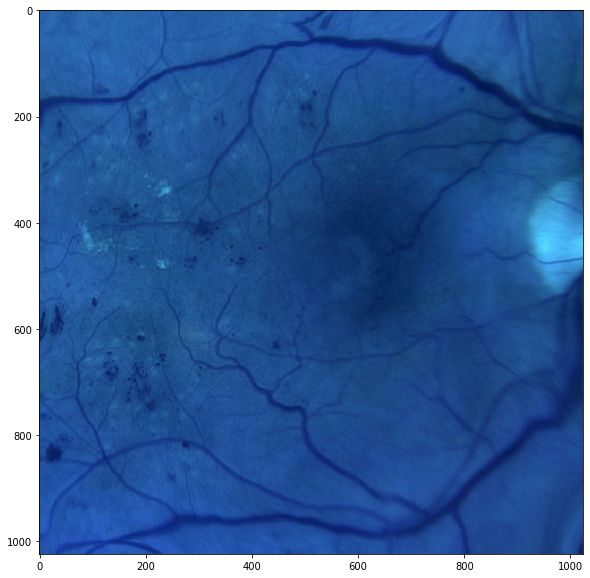

In [67]:
plt.figure(figsize=(10, 10))
plt.imshow(Xtrain[5])

In [1]:
def mutate_masks(masks, mapping):
    """
    Remaps classes on the given `masks` according to the `mapping`.
    Parameters
    ----------
    masks : list or numpy.array
        List or numpy array of masks.
    mapping : list
        List of tuples: [(source_class_number, new_class_number)],
        where `source_class_number` will be changed to `new_class_number` in the `masks`.
    Returns
    ---------
    new_masks : the same type as `masks`
        New masks with changed class numbers.
    """
    if type(mapping) is not list or (len(mapping) != 0 and type(mapping[0]) is not tuple):
        raise TypeError('mapping should be list of typles')

    new_masks = copy.deepcopy(masks)

    for i in range(len(new_masks)):
        for elem in mapping:
            old_value = elem[0]
            new_value = elem[1]
            new_masks[i][masks[i] == old_value] = new_value

    return  new_masks

In [11]:
def remove_4_class_from_pics(path_to_set):
    masks_name = glob(f'{path_to_set}/*.bmp')
    
    masks = [cv2.imread(name) for name in masks_name]
    masks = mutate_masks(masks, [(0, 0), (1, 1), (2, 2), (3, 3), (4, 0), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8)])
    
    for mask, name in zip(masks, masks_name):
        cv2.imwrite(name, mask)

In [12]:
batch_num = 1

In [20]:
for i in range(1, 4):
    path_to_set = f'/mnt/data/med_data/balanced_batches/batch_{i}/train_set/origin_wo_4_set/masks'
    remove_4_class_from_pics(path_to_set)